In [ ]:
# Install required libraries (if not already installed)
!pip install torch torchvision numpy matplotlib opencv-python scikit-learn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()


Saving archive.zip to archive (1).zip


In [ ]:
import zipfile
import os

# Extract the zip file
zip_file = 'archive.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('data')

# Check the extracted files
os.listdir('data')


['train', 'test']

In [ ]:
train_dir = 'data/train'
test_dir = 'data/test'


In [ ]:
# Define Image Transformations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((48, 48)),  # Resize images to 48x48 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])


In [ ]:
#Using ImageFolder from torchvision.datasets to load images from the directory structure.
# Load the training and test datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check class indices
print(train_dataset.class_to_idx)


{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
import torch.nn as nn

class BCosNet(nn.Module):
    def __init__(self, num_classes=7):
        super(BCosNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

        # B-Cos specific layer
        self.cosine = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 12 * 12)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        output = self.fc2(x)

        # B-Cos operation
        explanation = self.cosine(x, torch.randn_like(x))

        return output, explanation

# Instantiate the model
model = BCosNet(num_classes=len(train_dataset.classes))


In [ ]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch.nn as nn
import torch # Import torch here

In [ ]:
def train_model(model, criterion, optimizer, train_loader, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')

# Train the model
train_model(model, criterion, optimizer, train_loader, num_epochs=25)


Epoch [1/25], Loss: 725.6156
Epoch [2/25], Loss: 638.4901
Epoch [3/25], Loss: 588.3514
Epoch [4/25], Loss: 552.6292
Epoch [5/25], Loss: 516.9427
Epoch [6/25], Loss: 483.0360
Epoch [7/25], Loss: 449.4692
Epoch [8/25], Loss: 417.0031
Epoch [9/25], Loss: 384.6179
Epoch [10/25], Loss: 352.1941
Epoch [11/25], Loss: 322.3487
Epoch [12/25], Loss: 294.6814
Epoch [13/25], Loss: 270.7170
Epoch [14/25], Loss: 248.7241
Epoch [15/25], Loss: 230.9804
Epoch [16/25], Loss: 213.3640
Epoch [17/25], Loss: 199.9154
Epoch [18/25], Loss: 188.4724
Epoch [19/25], Loss: 174.1220
Epoch [20/25], Loss: 167.8115
Epoch [21/25], Loss: 156.5699
Epoch [22/25], Loss: 149.0509
Epoch [23/25], Loss: 141.0829
Epoch [24/25], Loss: 140.8520
Epoch [25/25], Loss: 132.0803


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model
evaluate_model(model, test_loader)


Test Accuracy: 55.89%


Shape of explanation: torch.Size([1])


TypeError: Invalid shape () for image data

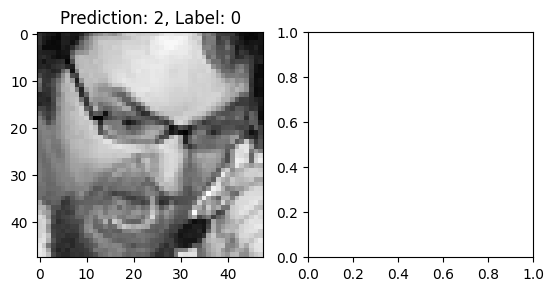

In [ ]:
import matplotlib.pyplot as plt

def visualize_explanation(model, input_image, label):
    model.eval()
    input_image = input_image.unsqueeze(0)
    # Check the output of the model
    output, explanation = model(input_image)
    print("Shape of explanation:", explanation.shape)  # Add this line to check the shape
    _, predicted = torch.max(output.data, 1)

    # Plot original image and explanation
    plt.subplot(1, 2, 1)
    plt.imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
    # Convert label to a tensor before calling .item()
    plt.title(f"Prediction: {predicted.item()}, Label: {torch.tensor(label).item()}")

    plt.subplot(1, 2, 2)
    # Check if explanation is empty before detaching and plotting
    if explanation is not None and explanation.numel() > 0:  # Check if explanation tensor exists and has elements
        plt.imshow(explanation.detach().squeeze().cpu().numpy(), cmap='viridis')
        plt.title("Explanation")
    else:
        plt.text(0.5, 0.5, "No Explanation Available", ha='center', va='center')
    plt.show()

# Visualize explanation for a sample image
visualize_explanation(model, test_dataset[0][0], test_dataset[0][1])